Install Packages

In [ ]:
!pip install torch torchvision matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms            # Molo!!
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Load Dataset (MNIST)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist = datasets.MNIST(root='./data', download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


Generator and Discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

Gradient Penalty Function

In [ ]:
def gradient_penalty(D, real, fake, device="cpu"):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated = (epsilon * real + (1 - epsilon) * fake).requires_grad_(True)

    d_interpolated = D(interpolated)
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, dim=1)
    penalty = ((grad_norm - 1) ** 2).mean()
    return penalty

WGAN-GP Training Loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
G = Generator().to(device)
D = Discriminator().to(device)

z_dim = 100
lr = 1e-4
lambda_gp = 10
n_critic = 5
epochs = 30

opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.0, 0.9))

D_losses, G_losses = [], []

for epoch in range(epochs):
    for i, (real, _) in enumerate(tqdm(dataloader)):
        real = real.to(device)
        batch_size = real.size(0)

        # Train Discriminator
        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim).to(device)
            fake = G(z).detach()
            d_real = D(real).mean()
            d_fake = D(fake).mean()
            gp = gradient_penalty(D, real, fake, device=device)                 # sh*t man, this is taking forever!!

            d_loss = -(d_real - d_fake) + lambda_gp * gp
            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake = G(z)
        g_loss = -D(fake).mean()

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        if i % 100 == 0:
            D_losses.append(d_loss.item())
            G_losses.append(g_loss.item())

    print(f"[Epoch {epoch+1}/{epochs}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 938/938 [00:37<00:00, 24.73it/s]


[Epoch 1/30] D Loss: -8.4341, G Loss: -3.0650


100%|██████████| 938/938 [00:36<00:00, 25.40it/s]


[Epoch 2/30] D Loss: -5.4161, G Loss: -2.7465


100%|██████████| 938/938 [00:37<00:00, 24.86it/s]


[Epoch 3/30] D Loss: -5.4027, G Loss: 0.0058


100%|██████████| 938/938 [00:36<00:00, 25.52it/s]


[Epoch 4/30] D Loss: -5.5234, G Loss: 3.2310


100%|██████████| 938/938 [00:37<00:00, 24.96it/s]


[Epoch 5/30] D Loss: -5.4242, G Loss: 3.7226


100%|██████████| 938/938 [00:36<00:00, 25.73it/s]


[Epoch 6/30] D Loss: -4.3694, G Loss: 4.5213


100%|██████████| 938/938 [00:36<00:00, 25.57it/s]


[Epoch 7/30] D Loss: -5.3558, G Loss: 3.8814


100%|██████████| 938/938 [00:36<00:00, 25.85it/s]


[Epoch 8/30] D Loss: -4.8519, G Loss: 1.8790


100%|██████████| 938/938 [00:36<00:00, 25.96it/s]


[Epoch 9/30] D Loss: -4.9266, G Loss: 2.4156


100%|██████████| 938/938 [00:36<00:00, 25.51it/s]


[Epoch 10/30] D Loss: -4.2631, G Loss: 1.7040


100%|██████████| 938/938 [00:37<00:00, 25.28it/s]


[Epoch 11/30] D Loss: -3.9177, G Loss: 1.2302


100%|██████████| 938/938 [00:37<00:00, 24.70it/s]


[Epoch 12/30] D Loss: -4.5178, G Loss: 0.7418


100%|██████████| 938/938 [00:37<00:00, 25.25it/s]


[Epoch 13/30] D Loss: -4.8906, G Loss: -0.0662


100%|██████████| 938/938 [00:37<00:00, 25.32it/s]


[Epoch 14/30] D Loss: -4.2525, G Loss: 1.4216


100%|██████████| 938/938 [00:37<00:00, 25.00it/s]


[Epoch 15/30] D Loss: -4.0240, G Loss: 0.7440


100%|██████████| 938/938 [00:37<00:00, 25.21it/s]


[Epoch 16/30] D Loss: -3.3158, G Loss: 0.5409


100%|██████████| 938/938 [00:37<00:00, 25.30it/s]


[Epoch 17/30] D Loss: -3.8055, G Loss: -0.0211


100%|██████████| 938/938 [00:37<00:00, 24.96it/s]


[Epoch 18/30] D Loss: -2.9532, G Loss: 0.1890


100%|██████████| 938/938 [00:38<00:00, 24.64it/s]


[Epoch 19/30] D Loss: -3.7367, G Loss: -0.5560


100%|██████████| 938/938 [00:37<00:00, 25.09it/s]


[Epoch 20/30] D Loss: -3.5270, G Loss: 0.6124


100%|██████████| 938/938 [00:37<00:00, 25.18it/s]


[Epoch 21/30] D Loss: -2.2501, G Loss: 0.1369


100%|██████████| 938/938 [00:37<00:00, 25.28it/s]


[Epoch 22/30] D Loss: -3.3631, G Loss: -0.1819


100%|██████████| 938/938 [00:37<00:00, 25.26it/s]


[Epoch 23/30] D Loss: -3.4203, G Loss: -0.6828


100%|██████████| 938/938 [00:36<00:00, 25.37it/s]


[Epoch 24/30] D Loss: -3.0615, G Loss: -0.5126


100%|██████████| 938/938 [00:36<00:00, 25.38it/s]


[Epoch 25/30] D Loss: -2.9411, G Loss: -0.3446


100%|██████████| 938/938 [00:37<00:00, 25.16it/s]


[Epoch 26/30] D Loss: -3.0074, G Loss: -0.4754


100%|██████████| 938/938 [00:36<00:00, 25.59it/s]


[Epoch 27/30] D Loss: -2.8774, G Loss: -0.1710


100%|██████████| 938/938 [00:36<00:00, 25.58it/s]


[Epoch 28/30] D Loss: -3.2228, G Loss: -0.4665


100%|██████████| 938/938 [00:36<00:00, 25.44it/s]


[Epoch 29/30] D Loss: -3.1941, G Loss: -0.1620


100%|██████████| 938/938 [00:36<00:00, 25.65it/s]

[Epoch 30/30] D Loss: -2.6802, G Loss: 0.0743


Visualize Loss and Generated Samples

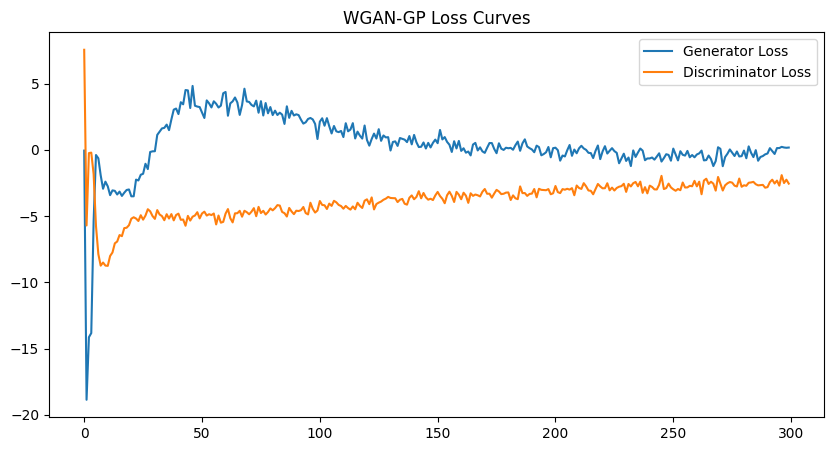

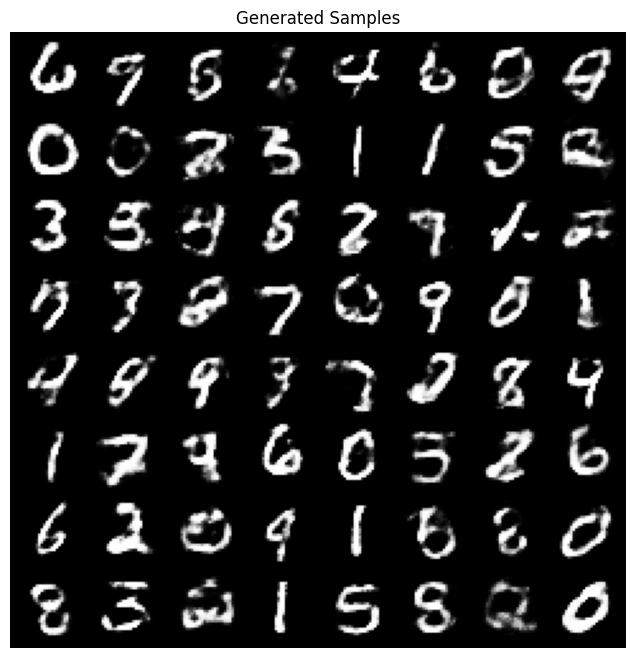

In [ ]:
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.legend()
    plt.title("WGAN-GP Loss Curves")
    plt.show()

def show_samples():
    with torch.no_grad():
        z = torch.randn(64, z_dim).to(device)
        samples = G(z)
        grid = make_grid(samples, nrow=8, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Generated Samples")
        plt.show()

plot_losses()
show_samples()

Standard GAN

In [ ]:
# Same generator structure
class GANGenerator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Standard Discriminator with sigmoid output
class GANDiscriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

Standard GAN - Training Loop

In [ ]:
gan_G = GANGenerator().to(device)
gan_D = GANDiscriminator().to(device)

criterion = nn.BCELoss()
opt_gan_G = optim.Adam(gan_G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_gan_D = optim.Adam(gan_D.parameters(), lr=2e-4, betas=(0.5, 0.999))

gan_D_losses, gan_G_losses = [], []

for epoch in range(epochs):
    for i, (real, _) in enumerate(tqdm(dataloader)):
        real = real.to(device)
        batch_size = real.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake = gan_G(z).detach()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)                     # chelsea gonna win the club world cup!

        real_loss = criterion(gan_D(real), real_labels)
        fake_loss = criterion(gan_D(fake), fake_labels)
        d_loss = real_loss + fake_loss

        opt_gan_D.zero_grad()
        d_loss.backward()
        opt_gan_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake = gan_G(z)
        g_loss = criterion(gan_D(fake), real_labels)

        opt_gan_G.zero_grad()
        g_loss.backward()
        opt_gan_G.step()

        if i % 100 == 0:
            gan_D_losses.append(d_loss.item())
            gan_G_losses.append(g_loss.item())

    print(f"[Epoch {epoch+1}/{epochs}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

100%|██████████| 938/938 [00:18<00:00, 49.38it/s]


[Epoch 1/30] D Loss: 0.4333, G Loss: 2.7267


100%|██████████| 938/938 [00:19<00:00, 49.25it/s]


[Epoch 2/30] D Loss: 0.2810, G Loss: 2.6059


100%|██████████| 938/938 [00:18<00:00, 49.56it/s]


[Epoch 3/30] D Loss: 0.2035, G Loss: 2.7317


100%|██████████| 938/938 [00:18<00:00, 50.91it/s]


[Epoch 4/30] D Loss: 0.3901, G Loss: 3.8371


100%|██████████| 938/938 [00:18<00:00, 49.66it/s]


[Epoch 5/30] D Loss: 0.3136, G Loss: 4.7211


100%|██████████| 938/938 [00:17<00:00, 52.47it/s]


[Epoch 6/30] D Loss: 0.2223, G Loss: 3.4431


100%|██████████| 938/938 [00:18<00:00, 50.80it/s]


[Epoch 7/30] D Loss: 0.2445, G Loss: 2.5299


100%|██████████| 938/938 [00:18<00:00, 51.23it/s]


[Epoch 8/30] D Loss: 0.1255, G Loss: 4.8338


100%|██████████| 938/938 [00:18<00:00, 50.72it/s]


[Epoch 9/30] D Loss: 0.3410, G Loss: 2.3521


100%|██████████| 938/938 [00:18<00:00, 51.95it/s]


[Epoch 10/30] D Loss: 0.2889, G Loss: 3.6326


100%|██████████| 938/938 [00:18<00:00, 50.53it/s]


[Epoch 11/30] D Loss: 0.2646, G Loss: 3.9186


100%|██████████| 938/938 [00:17<00:00, 52.99it/s]


[Epoch 12/30] D Loss: 0.6484, G Loss: 1.8723


100%|██████████| 938/938 [00:18<00:00, 50.18it/s]


[Epoch 13/30] D Loss: 0.6029, G Loss: 4.1186


100%|██████████| 938/938 [00:18<00:00, 51.56it/s]


[Epoch 14/30] D Loss: 0.4496, G Loss: 2.7578


100%|██████████| 938/938 [00:19<00:00, 48.62it/s]


[Epoch 15/30] D Loss: 0.5401, G Loss: 2.4572


100%|██████████| 938/938 [00:17<00:00, 52.71it/s]


[Epoch 16/30] D Loss: 0.4551, G Loss: 2.1660


100%|██████████| 938/938 [00:18<00:00, 50.56it/s]


[Epoch 17/30] D Loss: 1.0124, G Loss: 0.8884


100%|██████████| 938/938 [00:18<00:00, 51.48it/s]


[Epoch 18/30] D Loss: 0.5996, G Loss: 2.9595


100%|██████████| 938/938 [00:18<00:00, 51.17it/s]


[Epoch 19/30] D Loss: 0.7418, G Loss: 2.1376


100%|██████████| 938/938 [00:18<00:00, 50.97it/s]


[Epoch 20/30] D Loss: 0.5236, G Loss: 2.6364


100%|██████████| 938/938 [00:18<00:00, 50.21it/s]


[Epoch 21/30] D Loss: 0.5719, G Loss: 1.3048


100%|██████████| 938/938 [00:18<00:00, 50.25it/s]


[Epoch 22/30] D Loss: 1.1463, G Loss: 0.8186


100%|██████████| 938/938 [00:18<00:00, 51.33it/s]


[Epoch 23/30] D Loss: 0.7720, G Loss: 1.8064


100%|██████████| 938/938 [00:18<00:00, 50.61it/s]


[Epoch 24/30] D Loss: 0.6331, G Loss: 1.2944


100%|██████████| 938/938 [00:18<00:00, 51.68it/s]


[Epoch 25/30] D Loss: 0.8165, G Loss: 1.2054


100%|██████████| 938/938 [00:18<00:00, 50.52it/s]


[Epoch 26/30] D Loss: 0.7930, G Loss: 0.9665


100%|██████████| 938/938 [00:18<00:00, 51.64it/s]


[Epoch 27/30] D Loss: 1.0473, G Loss: 1.5690


100%|██████████| 938/938 [00:18<00:00, 50.35it/s]


[Epoch 28/30] D Loss: 0.8088, G Loss: 1.4371


100%|██████████| 938/938 [00:18<00:00, 50.57it/s]


[Epoch 29/30] D Loss: 1.5784, G Loss: 0.5948


100%|██████████| 938/938 [00:18<00:00, 49.57it/s]

[Epoch 30/30] D Loss: 0.7794, G Loss: 1.3126


Compare Loss Curves - WGAN vs Standard GAN

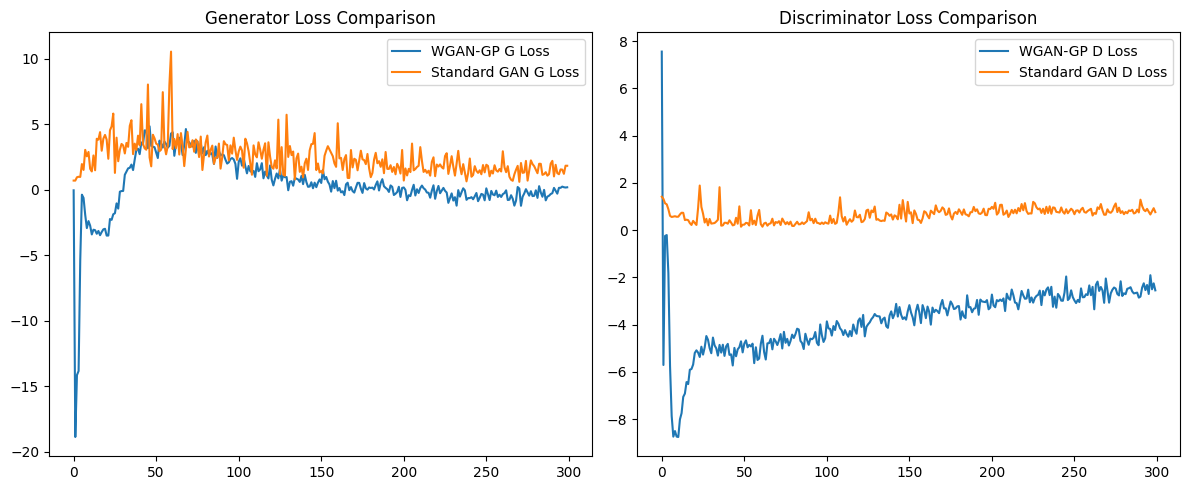

In [ ]:
plt.figure(figsize=(12, 5))

# Generator Losses
plt.subplot(1, 2, 1)
plt.plot(G_losses, label="WGAN-GP G Loss")
plt.plot(gan_G_losses, label="Standard GAN G Loss")
plt.title("Generator Loss Comparison")
plt.legend()

# Discriminator Losses
plt.subplot(1, 2, 2)
plt.plot(D_losses, label="WGAN-GP D Loss")
plt.plot(gan_D_losses, label="Standard GAN D Loss")
plt.title("Discriminator Loss Comparison")
plt.legend()

plt.tight_layout()
plt.show()

Compare Generated Samples

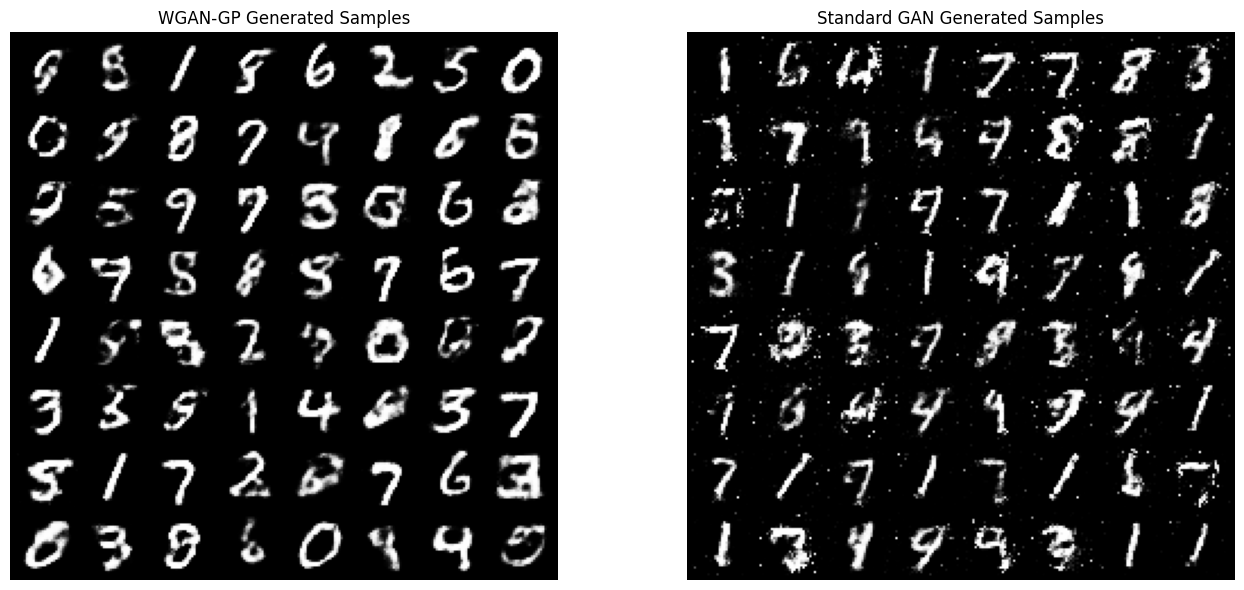

In [ ]:
def show_comparison_samples():
    with torch.no_grad():
        z = torch.randn(64, z_dim).to(device)

        wgan_samples = G(z)
        gan_samples = gan_G(z)

        wgan_grid = make_grid(wgan_samples, nrow=8, normalize=True)
        gan_grid = make_grid(gan_samples, nrow=8, normalize=True)

        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(wgan_grid.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("WGAN-GP Generated Samples")

        plt.subplot(1, 2, 2)
        plt.imshow(gan_grid.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Standard GAN Generated Samples")

        plt.tight_layout()
        plt.show()

show_comparison_samples()